In [1]:
from DPC import DPCModel
from FLORIS_PT import FLORIS_PT
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors
plt.rcParams.update({'font.size': 16})

### Inputs

In [2]:
# input files to define turbine type, wind conditions, and FLORIS model parameters
input_file_path = "./inputs.yaml"
floris_pt = FLORIS_PT(input_file_path)

# wind farm layout
D = floris_pt.turbine['rotor_diameter']
x_coord = torch.tensor([0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D])
            
y_coord = torch.tensor([6.*D, 6.*D, 6.*D,
                        3.*D, 3.*D, 3.*D,
                        0., 0., 0., ])
z_hh = floris_pt.turbine['hub_height']
nturbs = len(x_coord)
z_coord = torch.tensor([z_hh] * nturbs)

# dropout
dropout=True
active_prob = .5 # probability turbine is active during training

# set bounds on allowed yaw angle
umin = torch.tensor([0.]) # minimum allowed yaw angle (degrees)
umax = torch.tensor([25.]) # maximum allowed yaw angle (degrees)

# neural network parameters
model_config = dict({"n_turbines": nturbs, 
                     "hidden_dim": 128, 
                     "dropout": dropout})

# hyperparameters
lambda_ = 100. # scaling constant for penalty on constraint violations
lr = .00025
batch_size = 50
N_batches = 400
N_epochs = 2

# generate training data
# ws from [ws_min, ws_max]; m/s
ws_max = 8.0
ws_min = 3.0
ws_training = torch.rand((N_batches, batch_size, 1)) * (ws_max - ws_min) + ws_min 
# wd varies around wd_fixed; degrees
wd_fixed = 275.
wd_training = wd_fixed + .1*(torch.rand((N_batches, batch_size, 1)) -.5) 

# 1-8 turbines active
active_turbs_training = torch.rand((N_batches, batch_size, nturbs)) < active_prob
for batch in range(N_batches):
    for sample in range(batch_size):
        active_turbs= active_turbs_training[batch, sample, :]
        while torch.all(active_turbs == torch.tensor([False] * nturbs)):
            active_turbs_training[batch, sample, :] = torch.rand(nturbs) < active_prob

# pick validation set
ws_validation = torch.tensor([[4.], [6.], [8.]]) # m/s
wd_validation = torch.tensor([wd_fixed]) # degrees
active_turbs_validation = [torch.tensor([True, True, True, 
                                   True, True, True, 
                                   True, True, True]), 
                           torch.tensor([True, True, True, 
                                         True, True, True, 
                                         True, True, False]),
                           torch.tensor([True, True, True, 
                                         True, True, True, 
                                         True, False, False]),
                           torch.tensor([True, True, True, 
                                         True, True, False, 
                                         True, False, False])]

### Helper functions to apply DPC to FLORIS-PT

In [3]:
# get control action from DPC model
def get_control(model, ws, wd, inds_sorted, ws_max, wd_max=360., active_turbs=torch.tensor([False]*nturbs)):
    # normalize features to range [0,1] by dividing ws by ws_max and wd by wd_max
    x = torch.cat([ws/ws_max, wd/wd_max, active_turbs])
    u = model(x)
    clipped_u = torch.clone(u)*umax
    if active_turbs is not None:
        clipped_u = clipped_u[active_turbs]
    clipped_u_sorted = clipped_u[inds_sorted.flatten()]
    return clipped_u_sorted, clipped_u, u

# calculate average power over list of wind speeds
# modifies powers list to add this average power
def test_power(floris_pt, model, ws_all, wd, powers, x_coord, y_coord, z_coord, \
               ws_max, wd_max=360., active_turbs_all=None):
    
    for i in range(len(active_turbs_all)):
        active_turbs = active_turbs_all[i]
        # calculate avg power over wind speeds
        power = 0.
        
        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
            active_turbs=active_turbs)

        for ws in ws_all:
            # get control action
            clipped_u, _, _ = get_control(model, ws, wd, inds_sorted, \
            ws_max, wd_max, active_turbs=active_turbs)

            # calculate field on rotor mesh
            flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u, \
                x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted)

            # calculate turbine power
            p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)

            # add farm power
            power += torch.sum(p)
        power /= len(ws_all)
        powers[i].append(float(power.detach().numpy()))

### Training

In [4]:
# initialize DPC model
model = DPCModel(**model_config)

# initialize optimizer used for training
opt = torch.optim.Adam(model.parameters(), lr=lr)

# vectors to track training progress
opt_losses = []
powers_validation = [[] for i in range(len(active_turbs_validation))]

# calculate and record power over validation set 
# using control actions from untrained DPC policy
test_power(floris_pt, model, ws_validation, wd_validation, powers_validation, \
           x_coord, y_coord, z_coord, ws_max, \
           active_turbs_all=active_turbs_validation)

for epoch in range(1):
    for batch in range(N_batches):
        opt_loss = 0.

        # forward pass
        for sample in range(batch_size):
            ws = ws_training[batch, sample]
            wd = wd_training[batch, sample]
            active_turbs = active_turbs_training[batch, sample, :]

            # generate mesh on turbine rotor
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
                floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
                active_turbs=active_turbs)

            # get control action
            clipped_u, _, u = get_control(model, ws, wd, inds_sorted, ws_max, \
                active_turbs=active_turbs)

            # calculate field on rotor mesh
            flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u, \
                x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted)

            # calculate turbine power
            p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)

            # negative farm power (negative b/c optimizer minimizes loss)
            power_cost = -torch.sum(p)

            # sum over samples in batch
            opt_loss += power_cost / torch.sum(active_turbs)

        # normalize loss by batch size
        opt_loss /= batch_size

        # backward pass
        opt.zero_grad()
        opt_loss.backward()
        opt.step()
        
        # save losses
        opt_losses.append(opt_loss.detach().numpy())

        # calculate and record power over validation set 
        # using control actions from updated DPC policy
        test_power(floris_pt, model, ws_validation, wd_validation, powers_validation, \
               x_coord, y_coord, z_coord, ws_max, active_turbs_all=active_turbs_validation)
        
        # uncomment to track progress during training
#         if (batch+1) % 10 == 0:
#             print("batch: %d/%d."%(batch+1, N_batches))
#             plt.plot(np.array(powers_validation[0])-powers_validation[0][0], \
#                      color='tab:blue', linestyle='-', linewidth=3)
#             plt.plot(np.array(powers_validation[1])-powers_validation[1][0], \
#                      color='tab:orange', linestyle='--', linewidth=3)
#             plt.plot(np.array(powers_validation[2])-powers_validation[2][0], \
#                      color='tab:green', linestyle=':', linewidth=3)
#             plt.plot(np.array(powers_validation[3])-powers_validation[3][0], \
#                      color='tab:purple', linestyle=':', linewidth=3)
#             plt.xlabel('batch')
#             plt.ylabel('avg power over test set (kW)')
#             fig = plt.gcf()
#             fig.set_size_inches(12,6)
#             plt.show()

### FLORIS data

In [5]:
# ws =[3, 4, 5, 6, 7, 8]
# validaton ws=[4, 6, 8]

### 9 turbines ###

yaw_9t = [np.array([20.31, 20.31, 0., 
                       18.75, 18.75, 0., 
                       20.31, 18.75, 0.]),
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.   ]),
          np.array([18.75, 20.31, 0.,
                    15.6, 20.31, 0.,
                    18.75, 20.31, 0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.]),
          np.array([15.63, 20.31, 0., 
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.]),
          np.array([7.81, 6.25, 0., 
                    7.81, 6.25, 0.,
                    7.8125, 6.25, 0.])]

p_FLORIS_9t = np.array([12860.81, 8529.32, 5248.17, 2816.35, 1189.24, 212.07])
p_baseline_9t = np.array([11570.69, 7604.86, 4592.45, 2426.84, 981.51, 188.34])    
p_FLORIS_validation_9t = np.array([12860.81, 5248.17, 1189.24])
                      
### 8 turbines ###
yaw_8t = [np.array([20.31, 20.31, 0.,
                 20.31, 18.75, 0.,
                 18.75, 0.]), 
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0.,
                    18.75, 0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 20.31, 0.,
                    18.75, 0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    20.31, 0.]),
          np.array([15.63, 20.31, 0.,
                    15.63, 18.75, 0.,
                    20.31, 0.]),
          np.array([7.81, 6.25, 0., 
                    7.81, 6.25, 0.,
                    20.31, 0.])]
p_FLORIS_8t = np.array([11571.26, 7687.48, 4740.22, 2548.53, 1081.40, 195.62])
p_baseline_8t = np.array([10468.81, 6888.82, 4164.31, 2204.15, 893.72, 161.56])
p_FLORIS_validation_8t = np.array([11571.26, 4740.22, 1081.40])

    
### 7 turbines ###
yaw_7t = [np.array([20.31, 20.31, 0., 
                    20.31, 18.75, 0., 
                    0.]),
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0., 
                    0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 20.31, 0.,
                    0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    0.]),
          np.array([15.63, 20.31, 0.,
                    15.63, 18.75, 0.,
                    0.]),
          np.array([7.81, 6.25, 0.,
                    7.81, 6.25, 0.,
                    0.])] 
p_FLORIS_7t = np.array([10267.05, 6818.95, 4208.14, 2261.84, 961.89, 177.42])
p_baseline_7t = np.array([9405.13, 6201.89, 3762.19, 2001.59, 822.94, 161.56])
p_FLORIS_validation_7t = np.array([10267.05, 4208.14, 961.89])

### 6 turbines ###
yaw_6t = [np.array([20.31, 20.31, 0.,
                    18.75, 0.,
                    0.]),
          np.array([15.63, 18.75, 0.,
                    18.75, 0.,
                    0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 0.,
                    0.]),
          np.array([15.63, 21.88, 0.,
                    20.31, 0.,
                    0.]),
          np.array([15.63, 20.31, 0.,
                    20.31, 0.,
                    0.]),
          np.array([7.81, 6.25, 0.,
                    20.31, 0.,
                    0.])]
p_FLORIS_6t = np.array([8978.01, 5977.10, 3689.03, 1994.01, 854.04, 160.97])
p_baseline_6t = np.array([8303.25, 5485.85, 3334.04, 1778.90, 735.15, 134.79])
p_FLORIS_validation_6t = np.array([8978.01, 3689.03, 854.04])

### Training plot

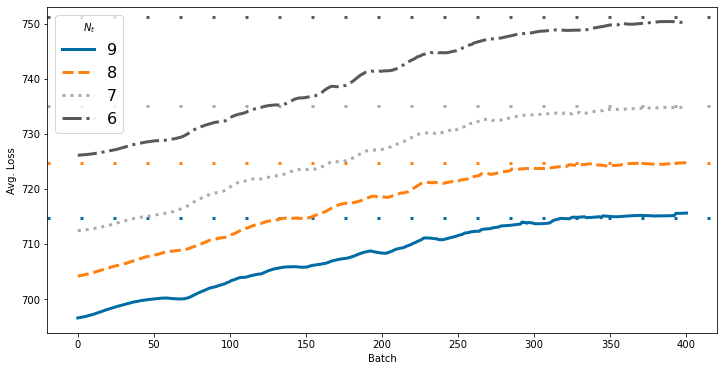

In [6]:
plt.style.use('tableau-colorblind10')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({'font.size': 20})
plt.rc('lines', linewidth=3.0)

linestyles = ['-', '--', ':', '-.']

markerstyles = ['+', 'x', '*', 'o']
marker_names = ["DPC", "Opt.", "Lookup", "Baseline"]

plt.rcParams.update({'lines.markersize': 15})

ps_FLORIS_validation = [p_FLORIS_validation_9t, p_FLORIS_validation_8t, \
                        p_FLORIS_validation_7t, p_FLORIS_validation_6t]

for i in range(4):
    nturbs_active = 9-i
    plt.plot(np.array(np.array(powers_validation[i])/nturbs_active), label=str(nturbs_active), 
             color=colors[i], linestyle=linestyles[i], linewidth=3)
    plt.axhline(np.mean(ps_FLORIS_validation[i])/nturbs_active, color=colors[i], linestyle=(0, (1, 10)), linewidth=3)
    
plt.legend(title="$N_t$", prop={'size': 16})
plt.xlabel('Batch')
plt.ylabel('Avg. Loss')
fig = plt.gcf()
fig.set_size_inches(12,6)
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/training.png', 
#             bbox_inches='tight')
plt.show()

# Loss averaged over the wind speeds in the validation set
# for each turbine status vector in the validation set, 
# labeled by the number of active turbines (6, 7, 8, or 9.)

### Testing plots

In [7]:
ps_DPC = []

for active_turbs in active_turbs_validation:
    ps_t = []
    for ws in torch.tensor([[8], [7], [6], [5], [4]]):
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
            active_turbs=active_turbs)

        clipped_u_sorted, clipped_u, u = get_control(model, ws, wd, inds_sorted, \
            ws_max, active_turbs=active_turbs)

        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u_sorted, \
            x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted)
        
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)
        
        ps_t.append(torch.sum(p).detach().numpy().flatten()[0])
        
    ps_DPC.append(np.array(ps_t))
ps_DPC.reverse()

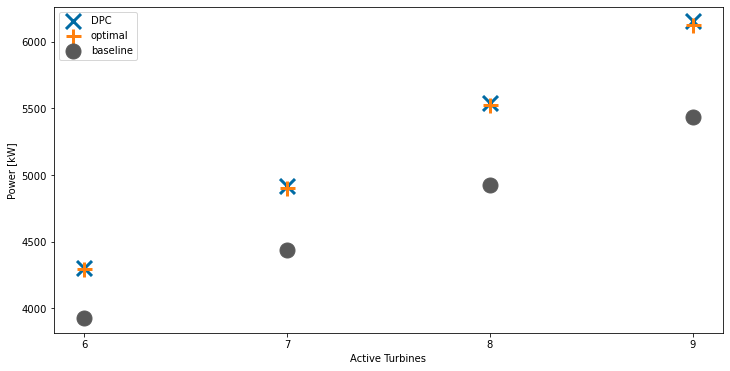

In [8]:
ps_FLORIS = [p_FLORIS_6t[:-1], p_FLORIS_7t[:-1], p_FLORIS_8t[:-1], p_FLORIS_9t[:-1]]
ps_baseline = [p_baseline_6t[:-1], p_baseline_7t[:-1], p_baseline_8t[:-1], p_baseline_9t[:-1]]

nturbs_active = [6, 7, 8, 9]
plt.scatter(nturbs_active, [np.mean(p) for p in ps_DPC], color=colors[0], \
            marker='x', label="DPC")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_FLORIS], color=colors[1], \
            marker='+', label="optimal")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_baseline], \
            marker='o', color=colors[3], label="baseline")
plt.xlabel("Active Turbines")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
ax=plt.gca()
plt.xticks(ticks=nturbs_active, labels=[str(nt) for nt in nturbs_active])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/testing_Nt.png', 
#             bbox_inches='tight')
plt.show()

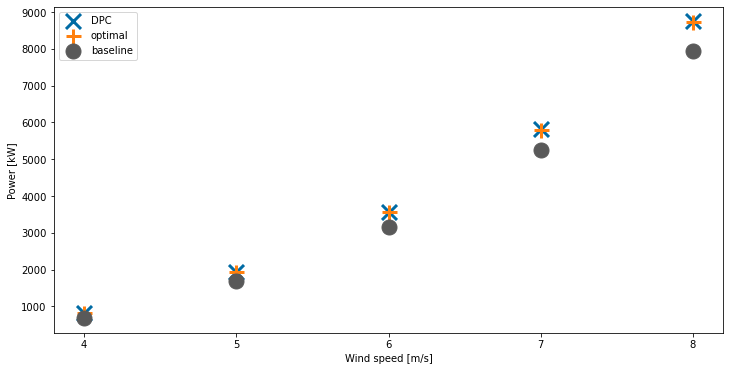

In [9]:
ws_plot =[4, 5, 6, 7, 8]
def t_to_ws(ps_t):
    ps_ws = np.zeros(len(ws_plot))
    for ps in ps_t:
        for i in range(len(ps)):
            ps_ws[i] += ps[i]
    ps_ws /= len(ws_plot)
    return np.flip(ps_ws)

ps_DPC_ws = t_to_ws(ps_DPC)
ps_FLORIS_ws = t_to_ws(ps_FLORIS)
ps_baseline_ws = t_to_ws(ps_baseline)


plt.scatter(ws_plot, ps_DPC_ws, color=colors[0], marker='x', label="DPC")
plt.scatter(ws_plot, ps_FLORIS_ws, color=colors[1], marker='+', label="optimal")
plt.scatter(ws_plot, ps_baseline_ws, marker='o', color=colors[3], label="baseline")
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/testing_u.png', 
#             bbox_inches='tight')
plt.show()

### yaw plots

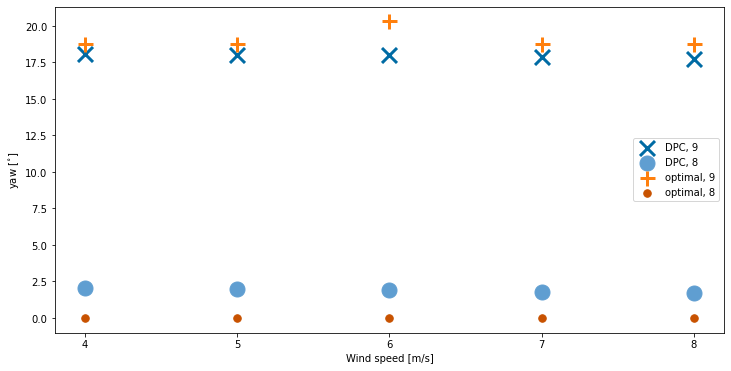

In [10]:
ws_plot =[4, 5, 6, 7, 8]
t1_9t_FLORIS = [yaw_9t_ws[7] for yaw_9t_ws in yaw_9t]
t1_8t_FLORIS = [yaw_8t_ws[7] for yaw_8t_ws in yaw_8t]
t1_9t_FLORIS.reverse()
t1_8t_FLORIS.reverse()

t1_9t_DPC = []
active_turbs = active_turbs_validation[0]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
        active_turbs=active_turbs)

    _, clipped_u, _ = get_control(model, ws, wd, inds_sorted, \
        ws_max, active_turbs=active_turbs)
    
    t1_9t_DPC.append(clipped_u[7].detach().numpy())

t1_8t_DPC = []
active_turbs = active_turbs_validation[1]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
        active_turbs=active_turbs)

    _, clipped_u, _ = get_control(model, ws, wd, inds_sorted, \
        ws_max, active_turbs=active_turbs)
    
    t1_8t_DPC.append(clipped_u[7].detach().numpy())
    
plt.scatter(ws_plot, t1_9t_DPC, color=colors[0], marker='x', label="DPC, 9")
plt.scatter(ws_plot, t1_8t_DPC, color=colors[4], marker='o', label="DPC, 8")
plt.scatter(ws_plot, t1_9t_FLORIS[1:], color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t1_8t_FLORIS[1:], color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/yaw_t1.png', 
#             bbox_inches='tight')
plt.show()

In [11]:
np.append(np.array(t1_9t_DPC) - np.array(t1_9t_FLORIS[1:]), 
                  np.array(t1_8t_DPC) - np.array(t1_8t_FLORIS[1:]))

array([-0.69458008, -0.70482254, -2.28548866, -0.85741806, -1.03929138,
        2.08350253,  1.98150969,  1.89525855,  1.81153178,  1.73042774])

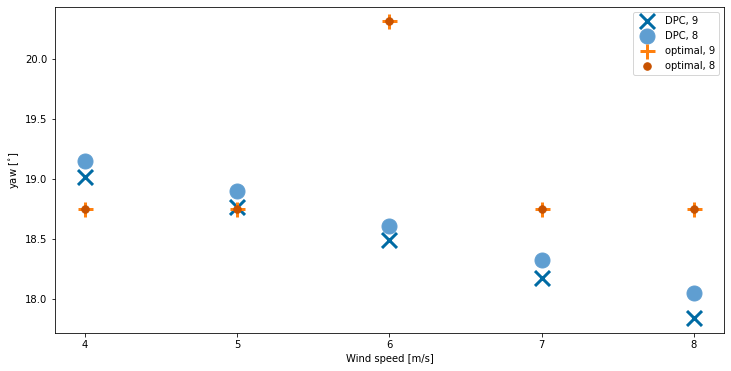

In [12]:
ws_plot =[4, 5, 6, 7, 8]
t2_9t_FLORIS = [yaw_9t_ws[4] for yaw_9t_ws in yaw_9t]
t2_8t_FLORIS = [yaw_8t_ws[4] for yaw_8t_ws in yaw_8t]
t2_9t_FLORIS.reverse()
t2_8t_FLORIS.reverse()

t2_9t_DPC = []
active_turbs = active_turbs_validation[0]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
        active_turbs=active_turbs)

    _, clipped_u, _ = get_control(model, ws, wd, inds_sorted, \
    ws_max, active_turbs=active_turbs)
    
    t2_9t_DPC.append(clipped_u[4].detach().numpy())

t2_8t_DPC = []
active_turbs = active_turbs_validation[1]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
        active_turbs=active_turbs)

    _, clipped_u, _ = get_control(model, ws, wd, inds_sorted, \
    ws_max, active_turbs=active_turbs)
    
    t2_8t_DPC.append(clipped_u[4].detach().numpy())
    
plt.scatter(ws_plot, t2_9t_DPC, color=colors[0], marker='x', label="DPC, 9")
plt.scatter(ws_plot, t2_8t_DPC, color=colors[4], marker='o', label="DPC, 8")
plt.scatter(ws_plot, t2_9t_FLORIS[1:], color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t2_8t_FLORIS[1:], color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/yaw_t2.png', 
#             bbox_inches='tight')
plt.show()

In [13]:
t2_9t_DPC[2]

array(18.490536, dtype=float32)

In [14]:
np.append(np.array(t2_9t_DPC) - np.array(t2_9t_FLORIS[1:]), 
                  np.array(t2_8t_DPC) - np.array(t2_8t_FLORIS[1:]))

array([ 0.26450348,  0.01305962, -1.81946426, -0.57687378, -0.90939331,
        0.39430809,  0.15209579, -1.7069841 , -0.42311478, -0.69802284])

In [15]:
wd = torch.tensor([wd_fixed])
ws = torch.tensor([6.])
active_turbs = torch.tensor([True, True, True,
                             True, True, True,
                             True, True, True])

x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord, \
        active_turbs=active_turbs)    

clipped_u = torch.tensor(yaw_9t[2])
clipped_u_sorted = clipped_u[inds_sorted.flatten()]
print("clipped u: ", np.round(clipped_u.detach().numpy(), 2))
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)
p1 = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p1).detach().numpy(), 1))
print("")

yaw_9t_alt = yaw_9t[2].copy()
yaw_9t_alt[4]=18.45
clipped_u = torch.tensor(yaw_9t_alt)
clipped_u_sorted = clipped_u[inds_sorted.flatten()]
print("clipped u: ", np.round(clipped_u.detach().numpy(), 2))
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)
p2 = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p2).detach().numpy(), 1))
print("")

yaw_9t_alt0 = yaw_9t[2].copy()
yaw_9t_alt0[4]=0.
clipped_u = torch.tensor(yaw_9t_alt0)
clipped_u_sorted = clipped_u[inds_sorted.flatten()]
print("clipped u: ", np.round(clipped_u.detach().numpy(), 2))
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)
p3 = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p3).detach().numpy(), 1))
print("")

clipped u:  [18.75 20.31  0.   15.6  20.31  0.   18.75 20.31  0.  ]
power:  5248.3

clipped u:  [18.75 20.31  0.   15.6  18.45  0.   18.75 20.31  0.  ]
power:  5247.8

clipped u:  [18.75 20.31  0.   15.6   0.    0.   18.75 20.31  0.  ]
power:  5172.1



In [16]:
(torch.sum(p1) - torch.sum(p2))/torch.sum(p1)*100

tensor(0.0085, dtype=torch.float64)

In [17]:
(torch.sum(p1) - torch.sum(p3))/torch.sum(p1)*100

tensor(1.4520, dtype=torch.float64)